In [123]:
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [124]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
        
    def forward(self, x):
        return self.conv(x)

In [125]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3): # 256x256 -> 30x30
        super().__init__()
        
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels=in_channels*2, out_channels=64, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2), # first bloack has no BatchNorm layer
        )
        
        self.model = nn.Sequential(
            
            CNNBlock(in_channels=64, out_channels=128, stride=2),
            CNNBlock(in_channels=128, out_channels=256, stride=2),
            CNNBlock(in_channels=256, out_channels=512, stride=1),
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"), # gives us 30x30 patches
        )
        
    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x

In [126]:
def test_discriminator():
    x = torch.randn((1, 3, 256, 256))
    y = torch.randn((1, 3, 256, 256))
    model = Discriminator()
    predictions = model(x, y)
    loss = nn.BCEWithLogitsLoss()(predictions, torch.zeros_like(predictions))
    print(loss)
    
test_discriminator()

# passed #

tensor(0.5855, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [127]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, use_ReLU=True, down=True, use_dropout=False):
        super().__init__()
        
        conv = []
                
        if down: # downsample or upsample depending on going down or not (up)
            conv.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1, bias=False, padding_mode="reflect"))
        else:
            conv.append(nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1, bias=False))
        
        conv.append(nn.BatchNorm2d(out_channels, affine=True))
        
        if use_ReLU:
            conv.append(nn.ReLU())
        else:
            conv.append(nn.LeakyReLU(0.2))
        
        self.conv = nn.Sequential(*conv)
        
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.conv(x)
        if self.use_dropout:
            x = self.dropout(x)
            
        return x

In [128]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        
        self.initial_down = nn.Sequential( # initial layer does not have batch norm
            nn.Conv2d(in_channels=in_channels, out_channels=features, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2)
        )
        
        # cant be sequential because we need to concat the down and up layers for skip connections
        
        self.down1 = Block(in_channels=features, out_channels=features*2, use_ReLU=False, down=True, use_dropout=False) # 64x64
        self.down2 = Block(in_channels=features*2, out_channels=features*4, use_ReLU=False, down=True, use_dropout=False) # 32x32
        self.down3 = Block(in_channels=features*4, out_channels=features*8, use_ReLU=False, down=True, use_dropout=False) # 16x16
        self.down4 = Block(in_channels=features*8, out_channels=features*8, use_ReLU=False, down=True, use_dropout=False) # 8x8
        self.down5 = Block(in_channels=features*8, out_channels=features*8, use_ReLU=False, down=True, use_dropout=False) # 4x4
        self.down6 = Block(in_channels=features*8, out_channels=features*8, use_ReLU=False, down=True, use_dropout=False) # 2x2

        
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels=features*8, out_channels=features*8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(), # 1x1
        )
        
        # all the *2's are for the skip connections where we concat the down to the previous up output over the channels dim
        
        self.up1 = Block(in_channels=features*8, out_channels=features*8, use_ReLU=True, down=False, use_dropout=True)
        self.up2 = Block(in_channels=features*8*2, out_channels=features*8, use_ReLU=True, down=False, use_dropout=True)
        self.up3 = Block(in_channels=features*8*2, out_channels=features*8, use_ReLU=True, down=False, use_dropout=True)
        self.up4 = Block(in_channels=features*8*2, out_channels=features*8, use_ReLU=True, down=False, use_dropout=False)
        self.up5 = Block(in_channels=features*8*2, out_channels=features*4, use_ReLU=True, down=False, use_dropout=False)
        self.up6 = Block(in_channels=features*4*2, out_channels=features*2, use_ReLU=True, down=False, use_dropout=False)
        self.up7 = Block(in_channels=features*2*2, out_channels=features, use_ReLU=True, down=False, use_dropout=False)
        
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(in_channels=features*2, out_channels=in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
        
    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        
        bottleneck = self.bottleneck(d7)
        
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], dim=1)) # skip connection with concat over channels dim
        up3 = self.up3(torch.cat([up2, d6], dim=1))
        up4 = self.up4(torch.cat([up3, d5], dim=1))
        up5 = self.up5(torch.cat([up4, d4], dim=1))
        up6 = self.up6(torch.cat([up5, d3], dim=1))
        up7 = self.up7(torch.cat([up6, d2], dim=1))
        
        final_up = self.final_up(torch.cat([up7, d1], dim=1))
        
        return final_up
        


In [129]:
def generator_test():
    x = torch.randn((1, 3, 256, 256))
    model = Generator(in_channels=3, features=64)
    predictions = model(x)
    print(predictions.shape)
    
generator_test()
# passed #

torch.Size([1, 3, 256, 256])


In [130]:
# ----- Hyperparameters ----- #
device = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 2e-4
BATCH_SIZE = 1
WORKERS = 2
IMAGE_SIZE = 256
IMAGE_CHANNELS = 3
LAMBDA = 100
EPOCHS = 150
LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_DISCRIMINATOR = 'discriminator.pth.tar'
CHECKPOINT_GENERATOR = 'generator.pth.tar'
print(f'{device=}')

device='cuda'


In [131]:
transforms_both = A.Compose(
    [A.Resize(width=IMAGE_SIZE, height=IMAGE_SIZE),], additional_targets={"image0": "image"},
)

transforms_input = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.2),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

transforms_mask = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)


In [132]:
class MapDataset(Dataset):
    def __init__(self, root):
        self.root = root
        self.files = os.listdir(root)
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        image_file = self.files[index]
        image_path = os.path.join(self.root, image_file)
        image = np.array(Image.open(image_path))
        input_image = image[:, :600, :]
        target_image = image[:, 600:, :]

        augmentations = transforms_both(image=input_image, image0=target_image)
        input_image = augmentations["image"]
        target_image = augmentations["image0"]

        input_image = transforms_input(image=input_image)["image"]
        target_image = transforms_mask(image=target_image)["image"]

        return input_image, target_image

torch.Size([5, 3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


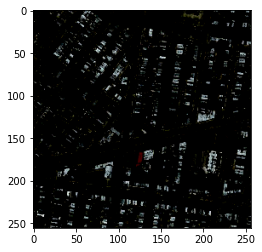

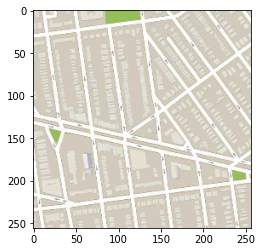

In [133]:
def dataset_test():
    dataset = MapDataset("../pix2pix-roads-dataset/maps/maps/train/")
    loader = DataLoader(dataset, batch_size=5)
    for x, y in loader:
        print(x.shape)
        plt.imshow(x[0].permute(1, 2, 0))
        plt.show()
        plt.imshow(y[0].permute(1, 2, 0))
        plt.show()
        break
    
dataset_test()
# passed #

In [134]:
def save_checkpoint(model, optimizer, filename):
    print('\nsaving checkpoint...\n')
    checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    
    torch.save(checkpoint, filename)
    
def load_checkpoint(model, optimizer, checkpoint_file):
    print('loading checkpoint...')
    #model.eval()
    model_dict = model.state_dict()
    #print(model_dict)
    checkpoint = torch.load(checkpoint_file, map_location=device)
    
    #pretrained_dict = {k: v for k, v in checkpoint['state_dict'].items() if k in model_dict}
    #print(checkpoint['state_dict'])
    #print(pretrained_dict)

    
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = LR # reset the learning rate

In [135]:
discriminator = Discriminator(in_channels=3).to(device)
generator = Generator(in_channels=3).to(device)

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))

BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

generator.eval()

if LOAD_MODEL:
    load_checkpoint(discriminator, optimizer_discriminator, CHECKPOINT_DISCRIMINATOR)
    load_checkpoint(generator, optimizer_generator, CHECKPOINT_GENERATOR)

loading checkpoint...
loading checkpoint...


In [136]:
train_dataset = MapDataset(root='../pix2pix-roads-dataset/maps/maps/train/')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = MapDataset(root='../pix2pix-roads-dataset/maps/maps/val/')
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=True)

In [137]:
def train():
    generator.train()
    discriminator.train()
    loop = tqdm(train_loader, total=len(train_loader), leave=False)
    for batch_index, (x, y) in enumerate(loop):
        x = x.to(device)
        y = y.to(device)
        
        y_fake = generator(x)
        
        # ----- Train Discriminator ----- #
        
        discriminator_on_reals = discriminator(x, y)
        discriminator_on_fakes = discriminator(x, y_fake.detach()) # we use detach on fake to prevent gradients from flowing back to the generator as this will be used for the discriminator only
        
        discriminator_loss_on_reals = BCE(discriminator_on_reals, torch.ones_like(discriminator_on_reals))
        discriminator_loss_on_fakes = BCE(discriminator_on_fakes, torch.zeros_like(discriminator_on_fakes))
        
        discriminator_loss = (discriminator_loss_on_reals + discriminator_loss_on_fakes) / 2
        
        optimizer_discriminator.zero_grad()
        discriminator_loss.backward()
        optimizer_discriminator.step()
        
        # ----- Train Generator ----- #
        
        discriminator_on_fakes = discriminator(x, y_fake) # now we don't detach fake as we want the gradients to flow back to the generator
        generator_loss_on_fakes = BCE(discriminator_on_fakes, torch.ones_like(discriminator_on_fakes))
        
        l1_loss = L1_LOSS(y_fake, y) * LAMBDA # we use L1 loss to ensure that the generated image is similar to the target image
        
        generator_loss = generator_loss_on_fakes + l1_loss
        
        optimizer_generator.zero_grad()
        generator_loss.backward()
        optimizer_generator.step()

In [ ]:
for epoch in range(EPOCHS):
    print(epoch)
    train()
    
    if SAVE_MODEL and epoch % 5 == 0:
        save_checkpoint(discriminator, optimizer_discriminator, CHECKPOINT_DISCRIMINATOR)
        save_checkpoint(generator, optimizer_generator, CHECKPOINT_GENERATOR)
    
    generator.eval()
    test_images = next(iter(val_loader))[0].to(device)
    image_grid = make_grid(generator(test_images), nrow=5, normalize=True).detach().permute(1, 2, 0).cpu().numpy()

    _ = plt.figure(figsize=(20, 20))
    _ = plt.yticks([])
    _ = plt.xticks([])
    plt.imshow(image_grid)

    plt.show()

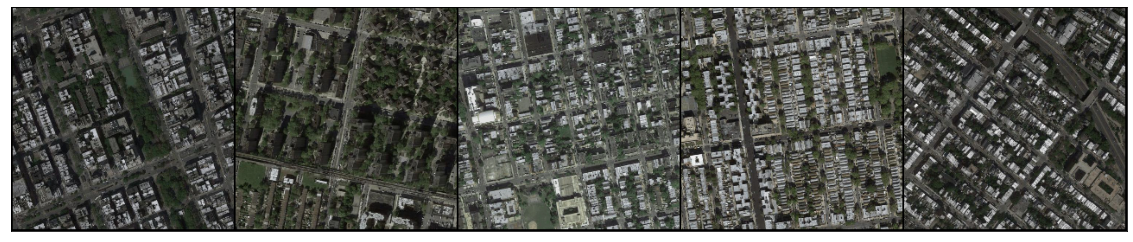

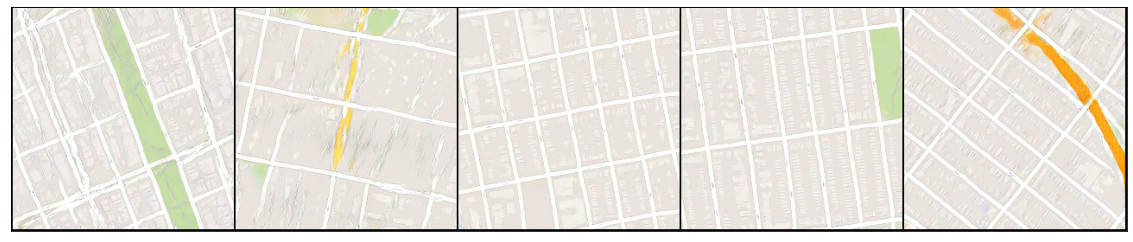

In [149]:
generator.eval()

test_images = next(iter(val_loader))[0].to(device)

image_grid = make_grid(test_images, nrow=5, normalize=True).detach().permute(1, 2, 0).cpu().numpy()

_ = plt.figure(figsize=(20, 20))
_ = plt.yticks([])
_ = plt.xticks([])
_ = plt.imshow(image_grid)

image_grid = make_grid(generator(test_images), nrow=5, normalize=True).detach().permute(1, 2, 0).cpu().numpy()

_ = plt.figure(figsize=(20, 20))
_ = plt.yticks([])
_ = plt.xticks([])
_ = plt.imshow(image_grid)
